# pip install packages if needed

```
pip install -r requirements.txt
```

In [1]:
# Import required libraries and set up our environment
from pprint import PrettyPrinter


# Import required libraries for web scraping
print("📚 Setting up the environment...")

import boto3
import requests
from bs4 import BeautifulSoup

import json
import re
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import os

S3_WIKI_BUCKET = "ceu-boga-2025"

print("✅ Libraries imported successfully")

print("📚 Setting up the environment...")
pp = PrettyPrinter(indent=2)
translate = boto3.client("translate", region_name="eu-west-1")
comprehend = boto3.client("comprehend")
s3 = boto3.client("s3")

print("✅ Environment setup complete!")
print(f"🌍 Using AWS region: {translate.meta.region_name}")

📚 Setting up the environment...
✅ Libraries imported successfully
📚 Setting up the environment...
✅ Environment setup complete!
🌍 Using AWS region: eu-west-1


In [2]:
# UDF - feed in URL,  returns dictionary with title, date, text, error
def scrape_article(url):

    def get_text_or_none(element):
        return element.get_text(strip=True) if element else None

    headers = {
        "User-Agent": "Mozilla/5.0 (compatible; CEU-Research-Bot/1.0)"
    }

    try:
        r = requests.get(url, headers=headers, timeout=15)
        r.raise_for_status()
    except Exception as e:
        return {
            "title": None,
            "date": None,
            "text": None,
            "error": str(e)
        }

    soup = BeautifulSoup(r.text, "html.parser")

    # ---- TITLE ----
    title = soup.find("h1") or soup.find("meta", property="og:title")
    title = title["content"] if title and title.name == "meta" else get_text_or_none(title)

    # ---- DATE ----
    date = (
        soup.find("time")
        or soup.find("meta", property="article:published_time")
        or soup.find("meta", attrs={"name": "date"})
    )
    date = date.get("datetime") or date.get("content") if date else None

    # ---- TEXT ----
    paragraphs = soup.find_all("p")
    text = "\n".join(
        p.get_text(strip=True)
        for p in paragraphs
        if len(p.get_text(strip=True)) > 40
    )

    return {
        "title": title,
        "date": date,
        "text": text,
        "error": None
    }


In [3]:
#translate non-english text, support function for UDF below
def translate_to_en(text, source_lang):
    """
    Translate text to English using Amazon Translate.
    Handles empty/NaN values.
    """
    if text is None or (isinstance(text, float) and pd.isna(text)) or str(text).strip() == "":
        return None

    resp = translate.translate_text(
        Text=text,
        SourceLanguageCode=source_lang,   # e.g. 'de', 'hu'
        TargetLanguageCode="en"
    )
    return resp["TranslatedText"]


In [4]:
# review dataframe, determine which rows have non-English text and call translation for only those rows
def translate_non_english_rows(df, text_col="text", lang_col="language", sleep_s=0.0):
    import time
    import pandas as pd

    df = df.copy()

    # add column if don't exist
    if "text_orig_ln" not in df.columns:
        df["text_orig_ln"] = pd.NA
    if "translate_error" not in df.columns:
        df["translate_error"] = pd.NA

    mask = (
        df[lang_col].notna()
        & (df[lang_col].str.lower() != "en")
        & df[text_col].notna()
    )

    # Freeze original text FIRST (never touch again)
    df.loc[mask, "text_orig_ln"] = df.loc[mask, text_col]

    # Translate without changing df directly
    translations = {}

    for idx, row in df.loc[mask, [text_col, lang_col]].iterrows():
        try:
            translations[idx] = translate_to_en(
                row[text_col],
                row[lang_col].lower()
            )
        except Exception as e:
            translations[idx] = None
            df.loc[idx, "translate_error"] = str(e)

        if sleep_s:
            time.sleep(sleep_s)

    #  sssign translations
    for idx, translated_text in translations.items():
        if translated_text:
            df.at[idx, text_col] = translated_text

    return df


In [5]:
# detect sentiment of english language text fed into UDF
def detect_sentiment_safe(
    text,
    language_code="en",
    max_bytes=4800
):
    # ---------- empty text ----------
    if text is None or (isinstance(text, float) and pd.isna(text)) or not str(text).strip():
        return {
            "sentiment": None,
            "chunk_sentiments": [],
            "positive": None,
            "neutral": None,
            "negative": None,
            "mixed": None,
            "n_units": 0,
            "unit_type": "sentence"
        }

    # ---------- sentence split ----------
    sentences = re.split(r"(?<=[.!?])\s+", text)
    sentences = [s for s in sentences if len(s.strip()) > 30]

    sentiments = []
    scores = []

    for s in sentences:
        if len(s.encode("utf-8")) > max_bytes:
            continue

        response = comprehend.detect_sentiment(
            Text=s,
            LanguageCode=language_code
        )

        sentiments.append(response["Sentiment"])
        scores.append(response["SentimentScore"])

    if not scores:
        return {
            "sentiment": None,
            "chunk_sentiments": [],
            "positive": None,
            "neutral": None,
            "negative": None,
            "mixed": None,
            "n_units": 0,
            "unit_type": "sentence"
        }

    # ---------- aggregate ----------
    avg_scores = {
        k: float(np.mean([s[k] for s in scores]))
        for k in scores[0]
    }


    # Because neutral sentences dominate long-form reporting, article sentiment was determined using average sentiment intensity 
    # rather than majority sentence labels.
    
    if avg_scores["Negative"] > avg_scores["Positive"] + 0.05:
        final_sentiment = "NEGATIVE"
    elif avg_scores["Positive"] > avg_scores["Negative"] + 0.05:
        final_sentiment = "POSITIVE"
    else:
        final_sentiment = "NEUTRAL"

    return {
        "sentiment": final_sentiment,
        "chunk_sentiments": sentiments,
        "positive": avg_scores["Positive"],
        "neutral": avg_scores["Neutral"],
        "negative": avg_scores["Negative"],
        "mixed": avg_scores["Mixed"],
        "n_units": len(sentences),
        "unit_type": "sentence"
    }


In [6]:
#get sentiment scores for translated articles,  and add to dataframe
def add_sentiment_scores(df, text_col="text", sleep_s=0.0):
    df = df.copy()
    results = {}

    for idx, text in df[text_col].items():
        try:
            res = detect_sentiment_safe(text)
            if res is None:
                res = {
                    "sentiment": None,
                    "positive": None,
                    "neutral": None,
                    "negative": None,
                    "mixed": None,
                    "sentiment_error": "empty_or_invalid_text"
                }
            results[idx] = res

        except Exception as e:
            results[idx] = {
                "sentiment": None,
                "positive": None,
                "neutral": None,
                "negative": None,
                "mixed": None,
                "sentiment_error": str(e)
            }

        if sleep_s:
            time.sleep(sleep_s)

    sentiment_df = pd.DataFrame.from_dict(results, orient="index")
    return pd.concat([df, sentiment_df], axis=1)



In [7]:
#store each row of a dataframe as a separate JSON file to S3 for archiving

def export_articles_to_s3_json(
    df,
    bucket_name,
    prefix="articles/",
    id_col="url"
):

    def make_json_safe(x):
        # pandas / numpy scalars
        if isinstance(x, (np.integer, np.floating)):
            return x.item()

        # timestamps
        if isinstance(x, pd.Timestamp):
            return time.strftime(
                "%Y-%m-%dT%H:%M:%S",
                time.localtime(x.value / 1e9)
            )

        # lists (e.g. chunk_sentiments)
        if isinstance(x, list):
            return x

        # missing values (scalar only!)
        if x is None:
            return None
        try:
            if pd.isna(x):
                return None
        except Exception:
            pass

        return x


    written_keys = []

    for idx, row in df.iterrows():
        record = {
            col: make_json_safe(row[col])
            for col in df.columns
        }

        # Safe, deterministic filename
        base_id = re.sub(r"[^a-zA-Z0-9]", "_", str(row[id_col]))[:80]
        filename = f"article_{idx}_{base_id}.json"
        s3_key = os.path.join(prefix, filename)

        s3.put_object(
            Bucket=bucket_name,
            Key=s3_key,
            Body=json.dumps(record, ensure_ascii=False, indent=2),
            ContentType="application/json"
        )

        written_keys.append(s3_key)

    return written_keys


In [8]:
# curated list of URLs was stored as a CSV file and read directly into a pandas DataFrame.
df_articles = pd.read_csv("curated_url_list.csv")
df_articles.head(20)

,url,language
0,https://www.bbc.com/news/technology-68546450,en
1,https://edition.cnn.com/2024/03/13/tech/ai-eur...,en
2,https://www.telegraph.co.uk/business/2024/09/1...,en
3,https://telex.hu/belfold/2025/06/16/magyar-mes...,hu
4,https://telex.hu/gazdasag/2024/09/17/nagy-mart...,hu
5,https://magyarnemzet.hu/gazdasag/2024/05/fokus...,hu
6,https://www.zeit.de/news/2025-08/02/neue-eu-re...,de
7,https://www.sueddeutsche.de/kultur/anja-braune...,de
8,https://www.derstandard.at/story/3000000255009...,de
9,https://ictglobal.hu/technologia/elesedik-az-e...,hu


In [9]:
# article URLs mapped to a scraping function that returns dictionaries,
# dictionaries expanded into tabular form and concatenated with the original metadata.

scraped_data = df_articles["url"].apply(scrape_article)
scraped_df = pd.concat([df_articles, scraped_data.apply(pd.Series)],axis=1)

scraped_df.head(20)

,url,language,title,date,text,error
0,https://www.bbc.com/news/technology-68546450,en,MEPs approve world's first comprehensive AI law,2024-03-13T11:59:32.000Z,The European Parliament has approved the world...,None
1,https://edition.cnn.com/2024/03/13/tech/ai-eur...,en,"EU approves landmark AI law, leapfrogging US t...",2024-03-13T12:04:17.775Z,European Union lawmakers gavefinal approvalWed...,None
2,https://www.telegraph.co.uk/business/2024/09/1...,en,Meddling Eurocrats are dragging the bloc back ...,2024-09-19T15:57+0100,"The EU’s ‘regulate first, ask questions later’...",None
3,https://telex.hu/belfold/2025/06/16/magyar-mes...,hu,Érkezhet a magyar Mesterséges Intelligencia Hi...,None,A magyar kormány Mesterséges Intelligencia Hiv...,None
4,https://telex.hu/gazdasag/2024/09/17/nagy-mart...,hu,Nagy Márton: A magyar vállalatok az AI-használ...,None,A kormány kiemelt célja a hazai kkv-k versenyk...,None
5,https://magyarnemzet.hu/gazdasag/2024/05/fokus...,hu,Fókuszba kerül a mesterséges intelligencia sza...,2024-05-21T16:03:24+02:00,A magyar uniós elnökség egyik központi témája ...,None
6,https://www.zeit.de/news/2025-08/02/neue-eu-re...,de,Künstliche Intelligenz:Neue EU-Regeln fordern ...,2025-08-02T00:01:38+02:00,"Wir entwickeln derzeit eine neue Suche, die si...",None
7,https://www.sueddeutsche.de/kultur/anja-braune...,de,Was das KI-Gesetz der EU für Kreative bringt,2024-06-09 13:11:10+0200,Das KI-Gesetz der EU schützt vor allem Verbrau...,None
8,https://www.derstandard.at/story/3000000255009...,de,AI Act: Ab Sonntag sind hochgefährliche KI-Anw...,2025-01-31T12:00\r\n,"Experten widersprechen der Behauptung, das Reg...",None
9,https://ictglobal.hu/technologia/elesedik-az-e...,hu,Élesedik az EU AI Act – Mire készüljünk fel?,None,Az Európai Unió Mesterséges Intelligencia Törv...,None


In [10]:
#backup so as we were troubleshooitng the code we did not hit the URLs too many times
scraped_backup = scraped_df.copy()

In [11]:
# translate non-english articles 
trans_art_df = translate_non_english_rows(scraped_df, text_col="text", lang_col="language", sleep_s=0.1)

trans_art_df.head(20)

,url,language,title,date,text,error,text_orig_ln,translate_error
0,https://www.bbc.com/news/technology-68546450,en,MEPs approve world's first comprehensive AI law,2024-03-13T11:59:32.000Z,The European Parliament has approved the world...,None,<NA>,<NA>
1,https://edition.cnn.com/2024/03/13/tech/ai-eur...,en,"EU approves landmark AI law, leapfrogging US t...",2024-03-13T12:04:17.775Z,European Union lawmakers gavefinal approvalWed...,None,<NA>,<NA>
2,https://www.telegraph.co.uk/business/2024/09/1...,en,Meddling Eurocrats are dragging the bloc back ...,2024-09-19T15:57+0100,"The EU’s ‘regulate first, ask questions later’...",None,<NA>,<NA>
3,https://telex.hu/belfold/2025/06/16/magyar-mes...,hu,Érkezhet a magyar Mesterséges Intelligencia Hi...,None,The Hungarian government plans to create an Ar...,None,A magyar kormány Mesterséges Intelligencia Hiv...,<NA>
4,https://telex.hu/gazdasag/2024/09/17/nagy-mart...,hu,Nagy Márton: A magyar vállalatok az AI-használ...,None,The main goal of the government is to develop ...,None,A kormány kiemelt célja a hazai kkv-k versenyk...,<NA>
5,https://magyarnemzet.hu/gazdasag/2024/05/fokus...,hu,Fókuszba kerül a mesterséges intelligencia sza...,2024-05-21T16:03:24+02:00,One of the central topics of the Hungarian EU ...,None,A magyar uniós elnökség egyik központi témája ...,<NA>
6,https://www.zeit.de/news/2025-08/02/neue-eu-re...,de,Künstliche Intelligenz:Neue EU-Regeln fordern ...,2025-08-02T00:01:38+02:00,We are currently developing a new search that ...,None,"Wir entwickeln derzeit eine neue Suche, die si...",<NA>
7,https://www.sueddeutsche.de/kultur/anja-braune...,de,Was das KI-Gesetz der EU für Kreative bringt,2024-06-09 13:11:10+0200,The EU's AI Act protects consumers in particul...,None,Das KI-Gesetz der EU schützt vor allem Verbrau...,<NA>
8,https://www.derstandard.at/story/3000000255009...,de,AI Act: Ab Sonntag sind hochgefährliche KI-Anw...,2025-01-31T12:00\r\n,Experts disagree with the claim that the regul...,None,"Experten widersprechen der Behauptung, das Reg...",<NA>
9,https://ictglobal.hu/technologia/elesedik-az-e...,hu,Élesedik az EU AI Act – Mire készüljünk fel?,None,Az Európai Unió Mesterséges Intelligencia Törv...,None,Az Európai Unió Mesterséges Intelligencia Törv...,An error occurred (TextSizeLimitExceededExcept...


In [12]:
#get sentiment scores for translated articles,  and add to dataframe

sent_trans_art_df  = add_sentiment_scores(trans_art_df, text_col="text", sleep_s=0.1)
sent_trans_art_df[['url', 'title', 'language', 'sentiment']].head(20)

,url,title,language,sentiment
0,https://www.bbc.com/news/technology-68546450,MEPs approve world's first comprehensive AI law,en,NEUTRAL
1,https://edition.cnn.com/2024/03/13/tech/ai-eur...,"EU approves landmark AI law, leapfrogging US t...",en,NEUTRAL
2,https://www.telegraph.co.uk/business/2024/09/1...,Meddling Eurocrats are dragging the bloc back ...,en,NEGATIVE
3,https://telex.hu/belfold/2025/06/16/magyar-mes...,Érkezhet a magyar Mesterséges Intelligencia Hi...,hu,NEUTRAL
4,https://telex.hu/gazdasag/2024/09/17/nagy-mart...,Nagy Márton: A magyar vállalatok az AI-használ...,hu,POSITIVE
5,https://magyarnemzet.hu/gazdasag/2024/05/fokus...,Fókuszba kerül a mesterséges intelligencia sza...,hu,POSITIVE
6,https://www.zeit.de/news/2025-08/02/neue-eu-re...,Künstliche Intelligenz:Neue EU-Regeln fordern ...,de,NEGATIVE
7,https://www.sueddeutsche.de/kultur/anja-braune...,Was das KI-Gesetz der EU für Kreative bringt,de,NEUTRAL
8,https://www.derstandard.at/story/3000000255009...,AI Act: Ab Sonntag sind hochgefährliche KI-Anw...,de,NEGATIVE
9,https://ictglobal.hu/technologia/elesedik-az-e...,Élesedik az EU AI Act – Mire készüljünk fel?,hu,NEUTRAL


In [13]:
#for each articles, export as separate JSON file to S3 for archiving
written_files = export_articles_to_s3_json(
    sent_trans_art_df,
    bucket_name=S3_WIKI_BUCKET,
    prefix="ai_act_articles/"
)

written_files

['ai_act_articles/article_0_https___www_bbc_com_news_technology_68546450.json',
 'ai_act_articles/article_1_https___edition_cnn_com_2024_03_13_tech_ai_european_union.json',
 'ai_act_articles/article_2_https___www_telegraph_co_uk_business_2024_09_19_meddling_eurocrats_dragging_bloc.json',
 'ai_act_articles/article_3_https___telex_hu_belfold_2025_06_16_magyar_mesterseges_intelligencia_hivatal_ai_.json',
 'ai_act_articles/article_4_https___telex_hu_gazdasag_2024_09_17_nagy_marton_a_magyar_vallalatok_az_ai_haszn.json',
 'ai_act_articles/article_5_https___magyarnemzet_hu_gazdasag_2024_05_fokuszba_kerul_a_mesterseges_intelligen.json',
 'ai_act_articles/article_6_https___www_zeit_de_news_2025_08_02_neue_eu_regeln_fordern_transparenz_von_ki_mo.json',
 'ai_act_articles/article_7_https___www_sueddeutsche_de_kultur_anja_brauneck_kuenstler_urheberrecht_copyrigh.json',
 'ai_act_articles/article_8_https___www_derstandard_at_story_3000000255009_ai_act_ab_sonntag_sind_hochgefaeh.json',
 'ai_act_articl

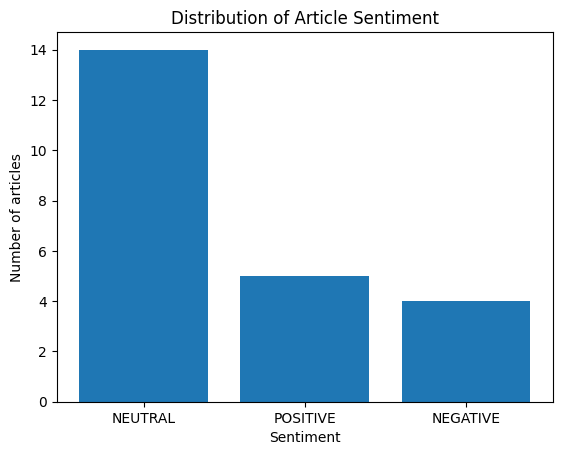

In [14]:
#generate histograms 
# Count sentiment labels (drop missing)
sent_counts = sent_trans_art_df["sentiment"].value_counts()

plt.figure()
plt.bar(sent_counts.index, sent_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Number of articles")
plt.title("Distribution of Article Sentiment")

plt.show()


In [16]:
# Drop rows with missing sentiment
df_plot = sent_trans_art_df.head(20).dropna(subset=["language", "sentiment"]).copy()

# Define explicit order
sentiment_order = ["NEGATIVE", "MIXED", "NEUTRAL", "POSITIVE"]

# Map sentiment to numeric y-values
sentiment_map = {s: i for i, s in enumerate(sentiment_order)}
df_plot["sentiment_num"] = df_plot["sentiment"].map(sentiment_map)

# Map language to numeric x-values
languages = df_plot["language"].unique()
language_map = {l: i for i, l in enumerate(languages)}
df_plot["language_num"] = df_plot["language"].map(language_map)


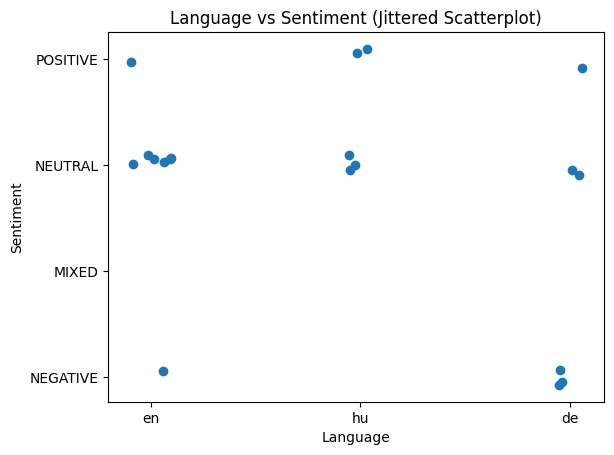

In [17]:
# Add jitter
x_jitter = df_plot["language_num"] + np.random.uniform(-0.1, 0.1, size=len(df_plot))
y_jitter = df_plot["sentiment_num"] + np.random.uniform(-0.1, 0.1, size=len(df_plot))

plt.figure()
plt.scatter(x_jitter, y_jitter)

# Axis labels
plt.xticks(list(language_map.values()), list(language_map.keys()))
plt.yticks(list(sentiment_map.values()), list(sentiment_map.keys()))

plt.xlabel("Language")
plt.ylabel("Sentiment")
plt.title("Language vs Sentiment (Jittered Scatterplot)")

plt.show()
